# Relationship Quality vs Student Performance 

Authors: Savanna Skinner, Sam Zhang, Yuvraj Grover

## Introduction


This project is centered around a data set comprised of student’s grades and lifestyle from a secondary school in Portugal. The data collected includes binary, numeric, and nominal variables, and for the purposes of this project only numeric and binary variables will be used. The goal of this project is to predict the final grade of a student in the Portugues secondary school data set without the use of the student’s previous grades to aid in the prediction. To make this prediction, different variables relating to the student’s familial and personal relationships will be used to determine a range for their language final grade using a KNN algorithm. With the Portuguese grading system this means students will fall into various categories from A, B, C, D, and F. The predictive question is that can we use the information of past student’s quality of familial and personal relationships to accurately predict the language grades of a future student?  



Since we wish to classify a student’s final grades based on his/her familial and personal relationships. We chose most of our variables that directly reflects the student’s relationship background, in specific, these variables are chosen to be:

1)     Famsize - family size (binary: "0" - less or equal to 3 or "1" - greater than 3)

2)     Pstatus - parent's cohabitation status (binary: '1' - living together or '0' - apart)

3)     famsup - family educational support (binary: "1" - yes or "0" - no)

4)     romantic - with a romantic relationship (binary: "1" - yes or "0" - no)

5)     famrel - quality of family relationships (numeric: from 1 - very bad to 5 - excellent)


TA: TODO!!! Explain why we choose these variables. Identify the intuitive links between these varaibles and their grades. Elaborate more on the "relationship"approach that we are taking in this project.


## Methods & Results

First, we need to wrangle the data such that all the binary explanatory variables are quantified into numerical values so we can perform classification using the KNN algorithm. Then, We will standardize all the values in the dataset, split the dataset into training and testing sets, then process classification. In addition, we will tune the classifier through cross-validation and pick the ideal K value that maximized the accuracy of our model. Finally, we will use the testing set to evalutate the performance of our model.

### 1) Loading and wrangling the data

In [169]:
library(tidyverse)
library(repr)
library(tidymodels)
library(dplyr)
library(digest)
library(infer)
library(cowplot)

student_data <- read_delim("data/student_por.csv", delim = ";",col_types = cols()) %>% 
                select(famsize,Pstatus,famsup,romantic,famrel,G3) %>% 
                mutate(G3 = case_when(G3=="0" ~ "F",
                                     G3=="1" ~ "F",
                                     G3=="2" ~ "F",
                                     G3=="3" ~ "F",
                                     G3=="4" ~ "D",
                                     G3=="5" ~ "D",
                                     G3=="6" ~ "D",
                                     G3=="7" ~ "D",
                                     G3=="8" ~ "C",
                                     G3=="9" ~ "C",
                                     G3=="10" ~ "C",
                                     G3=="11" ~ "C",
                                     G3=="12" ~ "B",
                                     G3=="13" ~ "B",
                                     G3=="14" ~ "B",
                                     G3=="15" ~ "B",
                                     G3=="16" ~ "A",
                                     G3=="17" ~ "A",
                                     G3=="18" ~ "A",
                                     G3=="19" ~ "A",
                                     G3=="20" ~ "A")) %>% 
               mutate(famsize = case_when(famsize == "GT3" ~ 1,
                                          famsize == "LE3" ~ 0)) %>% 
               mutate(Pstatus = case_when(Pstatus == "A" ~ 0,
                                          Pstatus == "T" ~ 1)) %>% 
               mutate(famsup = case_when(famsup == "no" ~ 0,
                                         famsup == "yes" ~ 1)) %>% 
               mutate(romantic = case_when(romantic == "no" ~ 0,
                                           romantic == "yes" ~ 1)) %>% 
               mutate(G3 = as_factor(G3))

student_data %>% 
select(G3) %>% 
pull() %>% 
levels()

head(student_data)


[1] "C" "B" "A" "D" "F"

famsize,Pstatus,famsup,romantic,famrel,G3
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,0,0,0,4,C
1,1,1,0,5,C
0,1,0,0,4,B
1,1,1,1,3,B
1,1,1,0,4,B
0,1,1,0,5,B


### 2) Summary and visualization

[1] "C" "B" "A" "D" "F"

`summarise()` regrouping output by 'G3' (override with `.groups` argument)

`summarise()` regrouping output by 'G3' (override with `.groups` argument)

`summarise()` regrouping output by 'G3' (override with `.groups` argument)

`summarise()` regrouping output by 'G3' (override with `.groups` argument)

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”


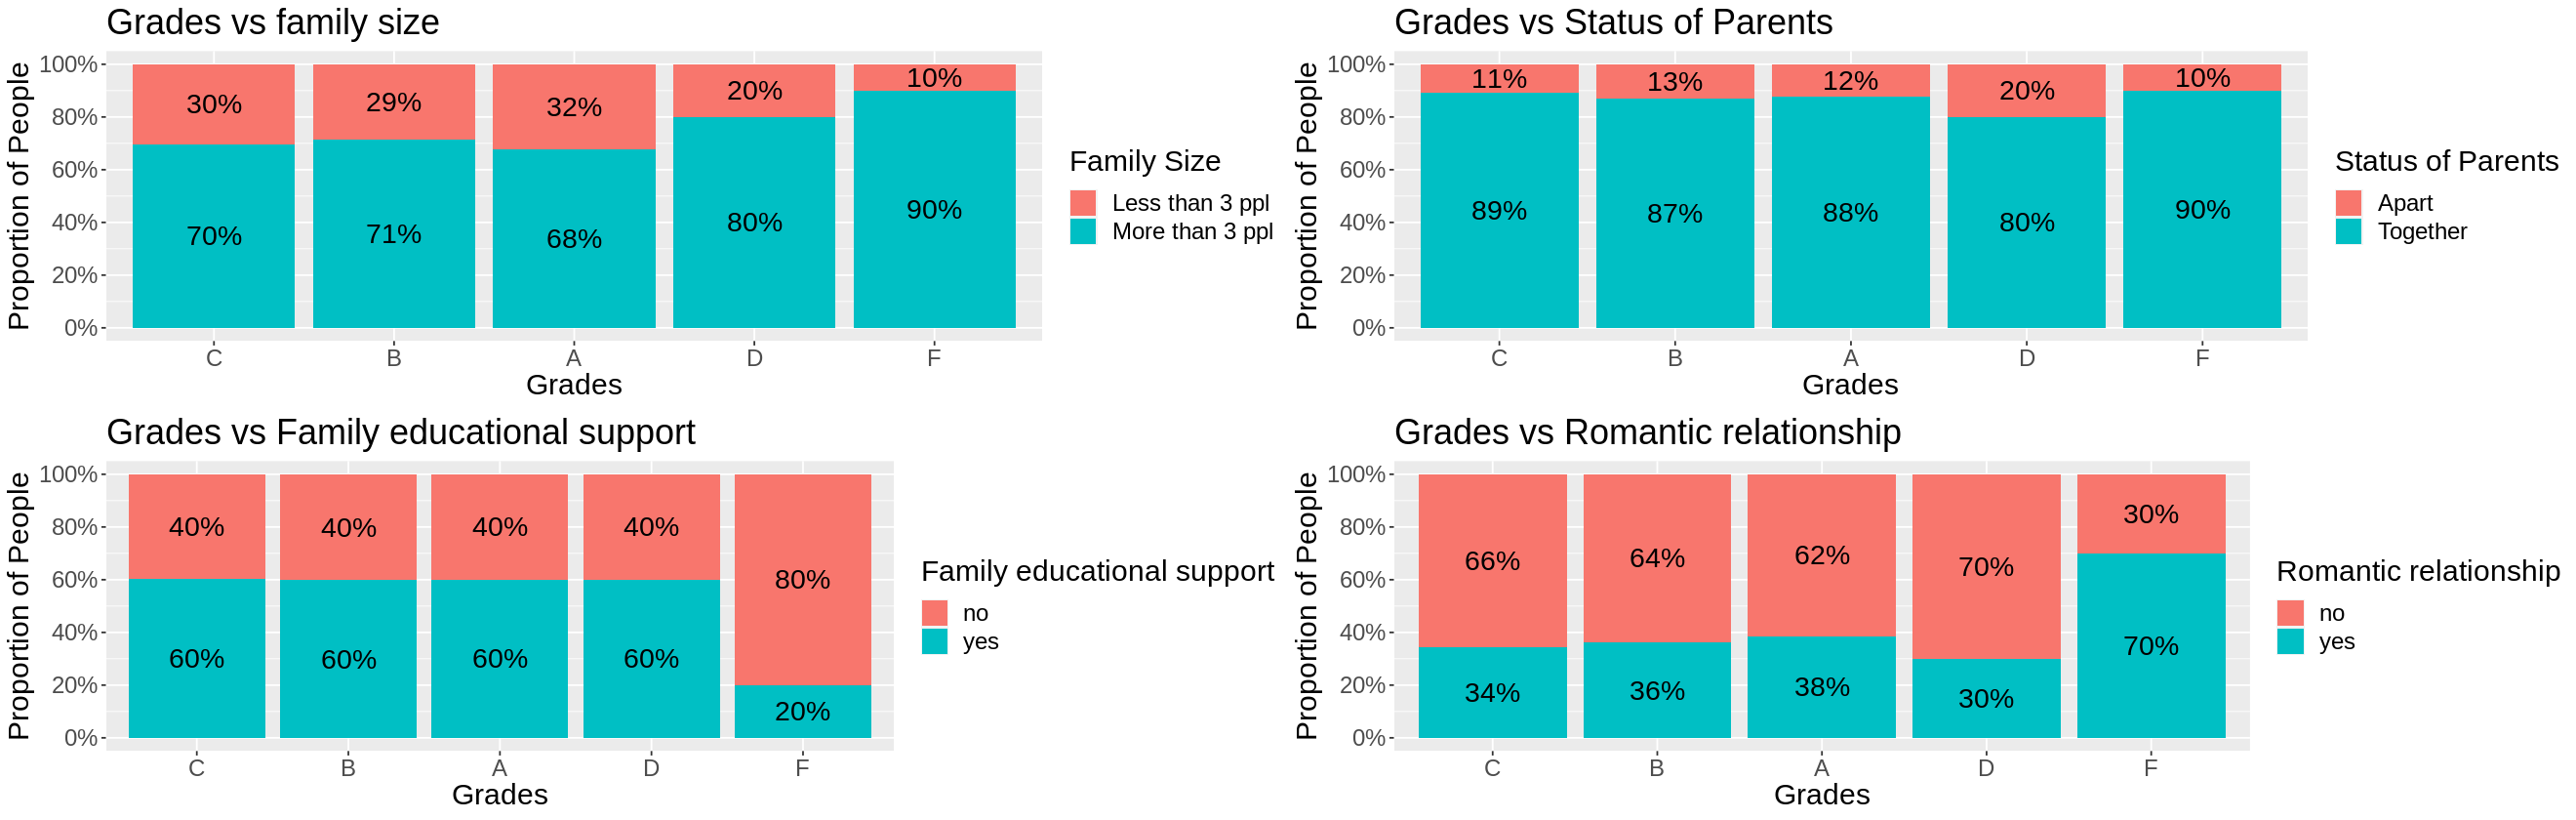

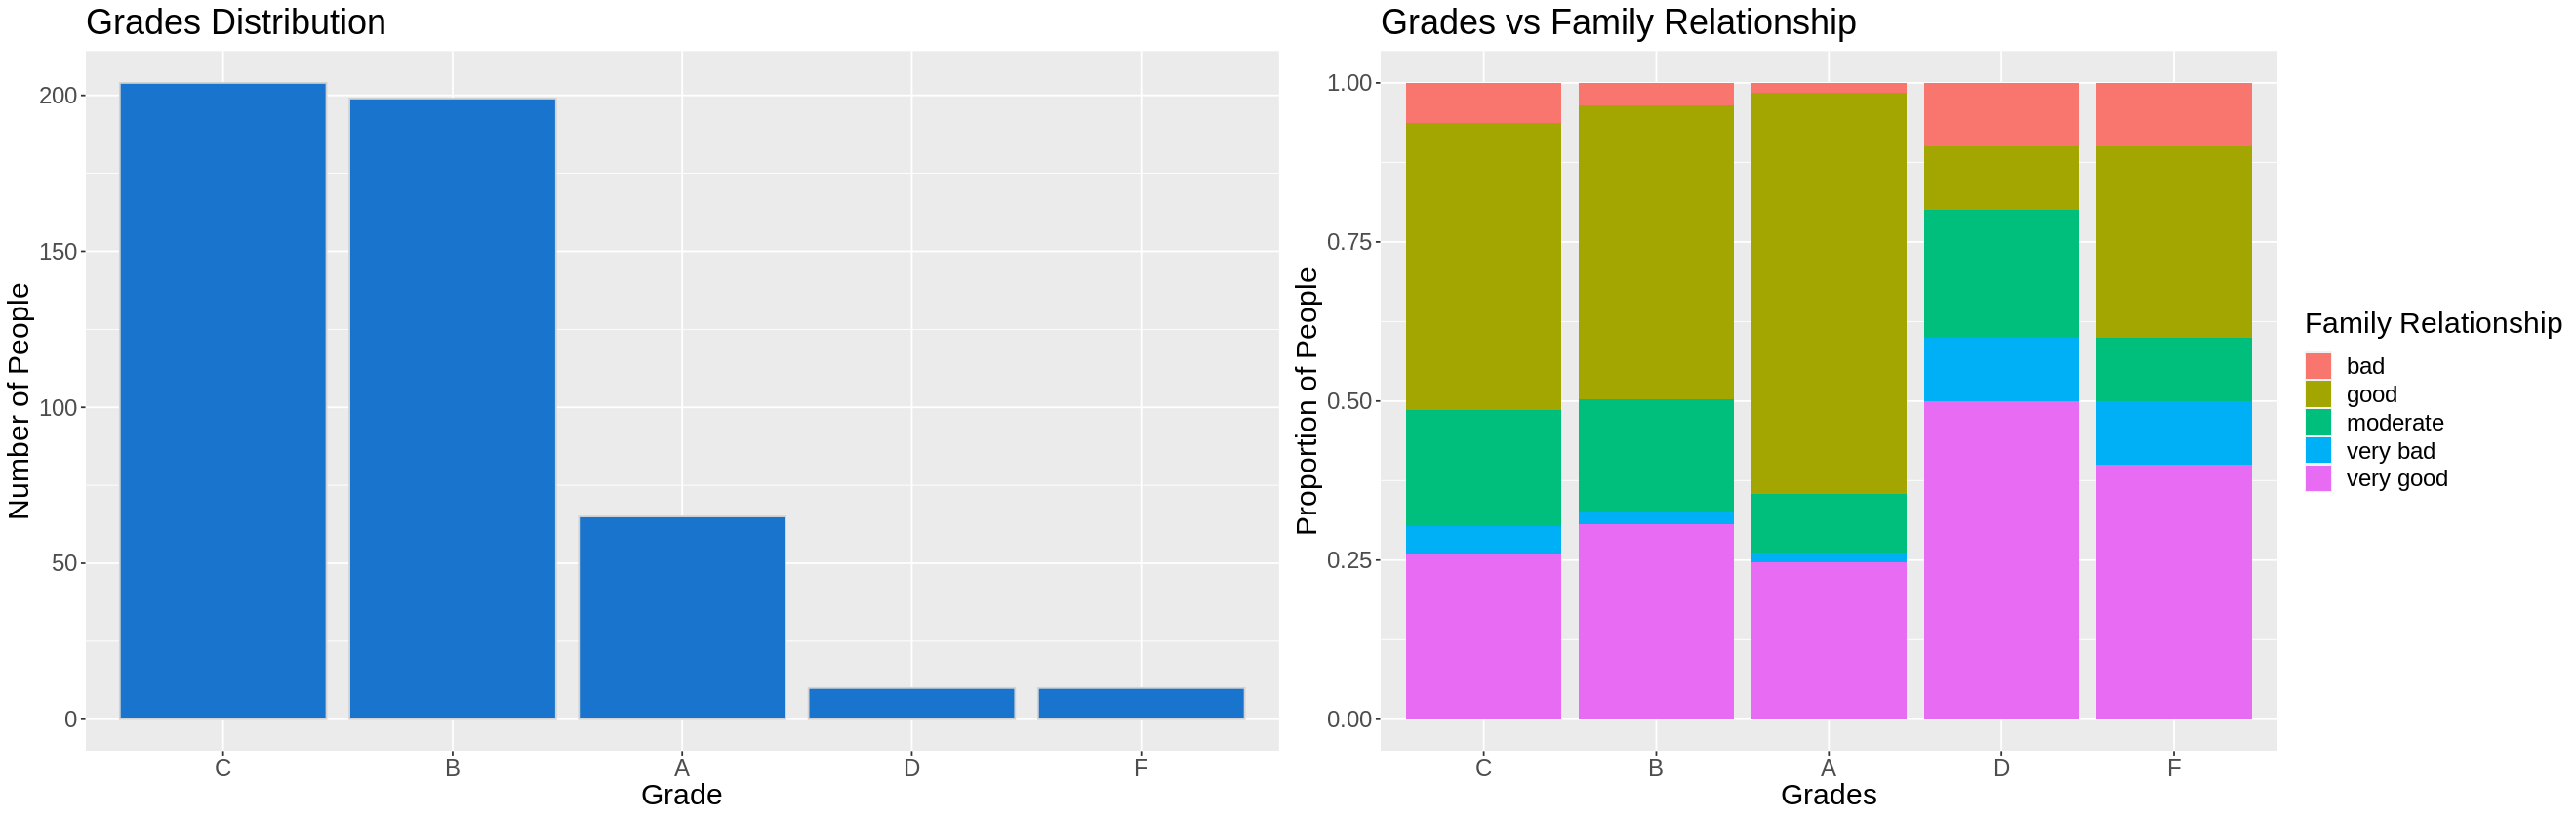

In [164]:
set.seed(1)
student_split <- initial_split(student_data, prop = 0.75, strata = G3)
student_train <- training(student_split)
student_test <- testing(student_split)

student_data_modified <- student_train %>%          #<------ reverting the columns into the "english" labels since its more intuitive for the plots
               mutate(famsize = case_when(famsize == 1 ~ "More than 3 ppl",
                                          famsize == 0 ~ "Less than 3 ppl")) %>% 
               mutate(Pstatus = case_when(Pstatus == 0 ~ "Apart",
                                          Pstatus == 1 ~ "Together")) %>% 
               mutate(famsup = case_when(famsup == 0 ~ "no",
                                         famsup == 1 ~ "yes")) %>% 
               mutate(romantic = case_when(romantic == 0 ~ "no",
                                           romantic == 1 ~ "yes")) %>% 
               mutate(famrel = case_when(famrel == 1 ~ "very bad",
                                        famrel == 2 ~ "bad",
                                        famrel == 3 ~ "moderate",
                                        famrel == 4 ~ "good",
                                        famrel == 5 ~ "very good"))

famsize_data <- student_data_modified %>% 
group_by(G3, famsize) %>% 
summarize(n = n()) %>% 
mutate(pct = n/sum(n),
       lbl = scales::percent(pct))

pstatus_data <- student_data_modified %>% 
group_by(G3, Pstatus) %>% 
summarize(n = n()) %>% 
mutate(pct = n/sum(n),
       lbl = scales::percent(pct))

famsup_data <- student_data_modified %>% 
group_by(G3, famsup) %>% 
summarize(n = n()) %>% 
mutate(pct = n/sum(n),
       lbl = scales::percent(pct))

romantic_data <- student_data_modified %>% 
group_by(G3, romantic) %>% 
summarize(n = n()) %>% 
mutate(pct = n/sum(n),
       lbl = scales::percent(pct))

student_fam_vs_grades_plot <- ggplot(famsize_data, aes(x = G3, y = pct, fill = famsize)) +
    geom_bar(stat = "identity", position = "fill") +
    scale_y_continuous(breaks = seq(0, 1, .2), label = percent) +
    geom_text(aes(label = lbl), 
            size = 6, 
            position = position_stack(vjust = 0.5)) +
    labs(x = "Grades", y = "Proportion of People", fill = "Family Size") + 
    theme(text = element_text(size = 18)) +
    ggtitle("Grades vs family size")

student_Pstatus_vs_grades_plot <- ggplot(pstatus_data, aes(x = G3, y = pct, fill = Pstatus)) +
    geom_bar(stat = "identity", position = "fill") +
    scale_y_continuous(breaks = seq(0, 1, .2), label = percent) +
    geom_text(aes(label = lbl), 
            size = 6, 
            position = position_stack(vjust = 0.5)) +
    labs(x = "Grades", y = "Proportion of People", fill = "Status of Parents") + 
    theme(text = element_text(size = 18)) +
    ggtitle("Grades vs Status of Parents")

student_famsup_vs_grades_plot <- ggplot(famsup_data, aes(x = G3, y = pct, fill = famsup)) +
    geom_bar(stat = "identity", position = "fill") +
    scale_y_continuous(breaks = seq(0, 1, .2), label = percent) +
    geom_text(aes(label = lbl), 
            size = 6, 
            position = position_stack(vjust = 0.5)) +
    labs(x = "Grades", y = "Proportion of People", fill = "Family educational support") + 
    theme(text = element_text(size = 18)) +
    ggtitle("Grades vs Family educational support")

student_romantic_vs_grades_plot <- ggplot(romantic_data, aes(x = G3, y = pct, fill = romantic)) +
    geom_bar(stat = "identity", position = "fill") +
    scale_y_continuous(breaks = seq(0, 1, .2), label = percent) +
    geom_text(aes(label = lbl), 
            size = 6, 
            position = position_stack(vjust = 0.5)) +
    labs(x = "Grades", y = "Proportion of People", fill = "Romantic relationship") + 
    theme(text = element_text(size = 18)) +
    ggtitle("Grades vs Romantic relationship")


student_familyRelationship_vs_grades_plot<-ggplot(student_data_modified,aes(x = G3, fill = famrel))+
    geom_bar(position="fill")+
    labs(x = "Grades", y = "Proportion of People", fill = "Family Relationship") +
    theme(text = element_text(size = 18)) +
    ggtitle("Grades vs Family Relationship")

student_grades_distribution_plot <- ggplot(student_data_modified,aes(x = G3))+
    geom_histogram(fill = "dodgerblue3", color = "lightgrey", bins = 10, stat  = "count")+
    xlab("Grade")+
    ylab("Number of People")+
    theme(text = element_text(size = 18)) +
    ggtitle("Grades Distribution")

student_distribution_panel_1 <- plot_grid(student_fam_vs_grades_plot,
                   student_Pstatus_vs_grades_plot,
                   student_famsup_vs_grades_plot,
                   student_romantic_vs_grades_plot,      
                   ncol = 2)

student_distribution_panel_2 <- plot_grid(student_grades_distribution_plot,
                    student_familyRelationship_vs_grades_plot,
                    ncol = 2)

student_distribution_panel_1
student_distribution_panel_2

### 3) Data Analysis

! Fold02: internal: No observations were detected in `truth` for level(s): 'F'
Com...

! Fold04: internal: No observations were detected in `truth` for level(s): 'D'
Com...

! Fold07: internal: No observations were detected in `truth` for level(s): 'D'
Com...

! Fold10: internal: No observations were detected in `truth` for level(s): 'D'
Com...



neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
25,accuracy,multiclass,0.4328617,10,0.02129612,Model25
23,accuracy,multiclass,0.4325177,10,0.02427078,Model23
39,accuracy,multiclass,0.4311613,10,0.02480923,Model39


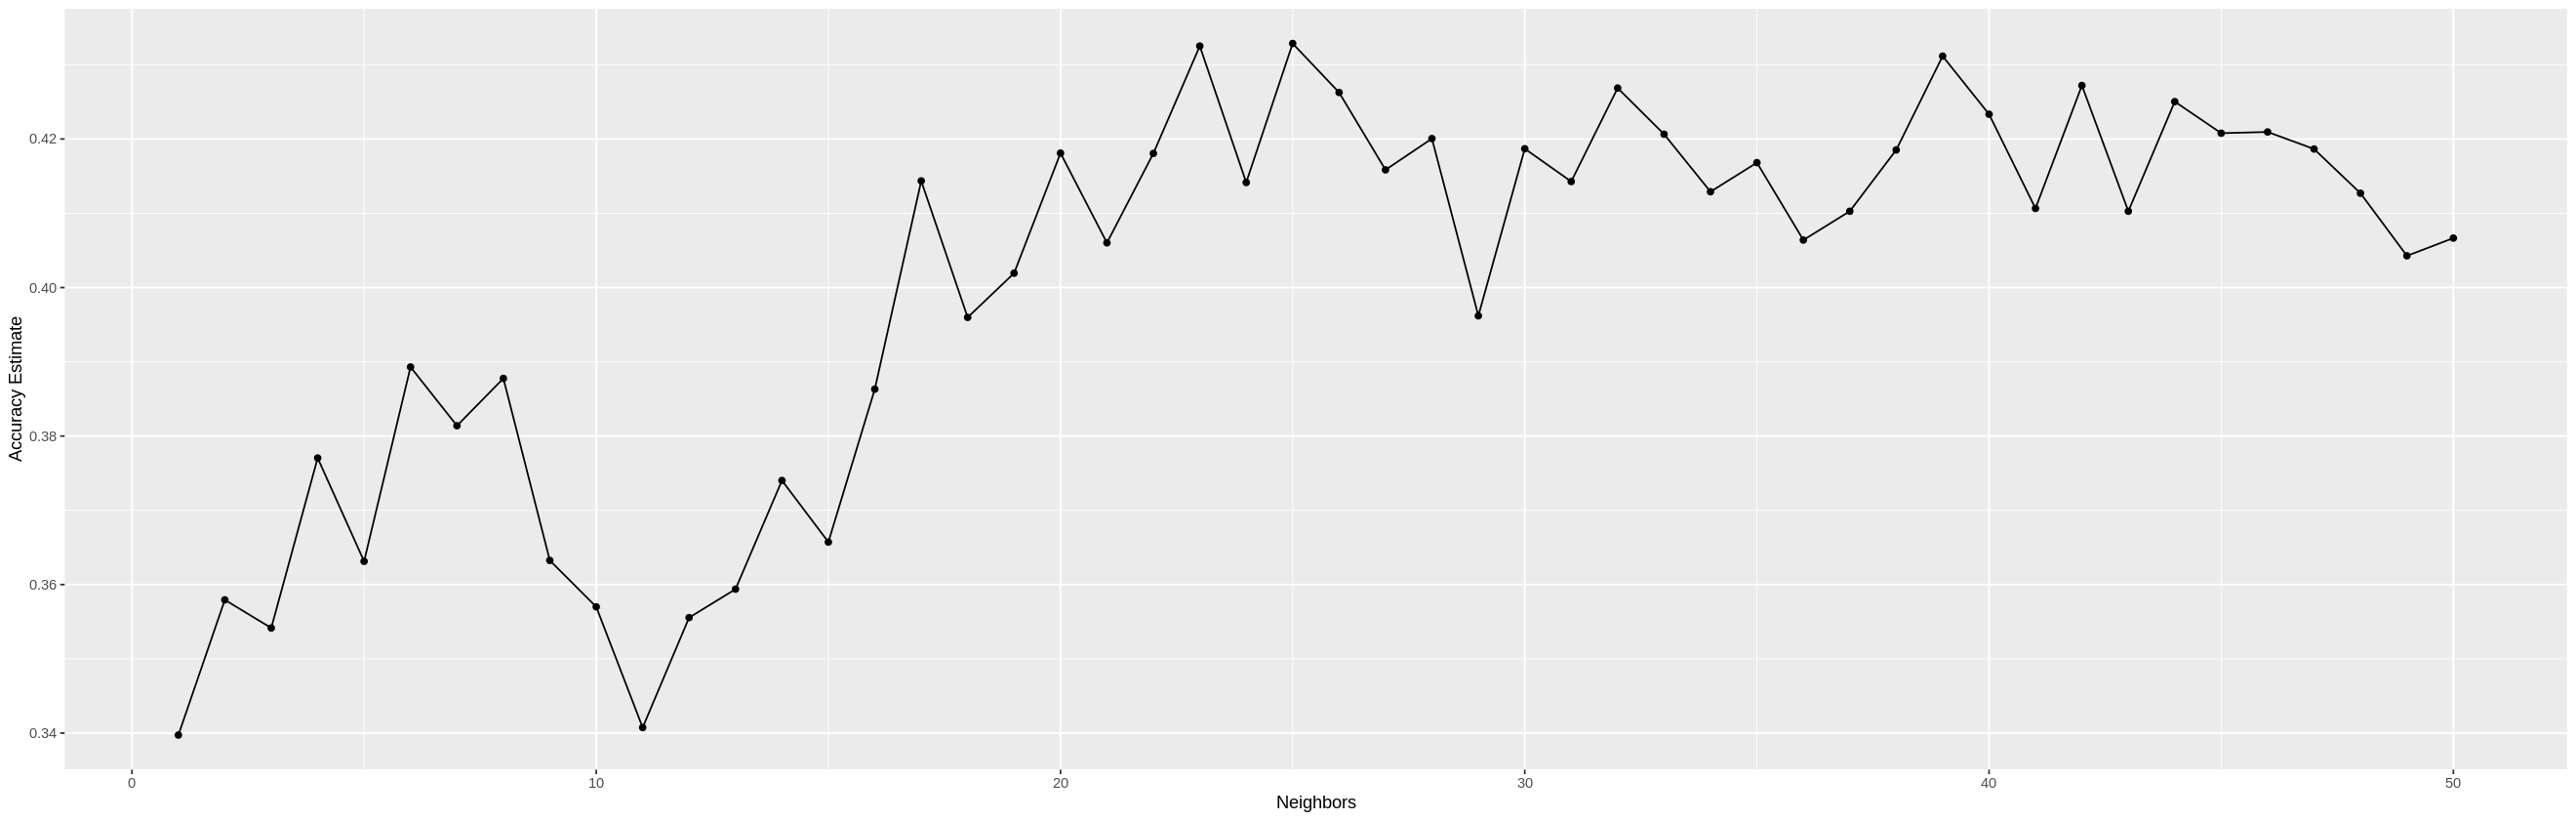

In [147]:
#summary(student_data)
set.seed(1)
student_recipe <- recipe(G3 ~. , data = student_train) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
  set_engine("kknn") %>%
  set_mode("classification")

student_vfold <- vfold_cv(student_train, v = 10, strata = G3)

gridvals <- tibble(neighbors = seq(1,50))

knn_results <- workflow() %>%
  add_recipe(student_recipe) %>%
  add_model(knn_spec) %>%
  tune_grid(resamples = student_vfold, grid = gridvals) %>%
  collect_metrics()

accuracies <- knn_results %>%
  filter(.metric == "accuracy")

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate")

best_k <- knn_results %>%                 #<------ Gives us top 3 k values 
  filter(.metric == "accuracy") %>% 
  arrange(desc(mean)) %>% 
  slice(1:3)

best_k
accuracy_vs_k

In [148]:
set.seed(1)
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 39) %>%
  set_engine("kknn") %>%
  set_mode("classification")

knn_fit <- workflow() %>%
  add_recipe(student_recipe) %>%
  add_model(knn_spec) %>%
  fit(data = student_train)

student_test_predictions <- predict(knn_fit, student_test) %>% 
  bind_cols(student_test) %>% 
  metrics(truth = G3, estimate = .pred_class)
  #conf_mat(truth = G3, estimate = .pred_class)

student_test_predictions

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.43478261
kap,multiclass,0.03191489


## Discussion

Expected outcomes and significance

We expect that the students with healthier familial and personal relationships will achieve greater success in their academics, as they will be in a more positive environment which seems likely to foster higher achievement in school. By examining this connection between grades and a student’s relationships, we can develop a better understanding of the influence of non-academic factors on a student’s performance in school. In the future we could determine which non-academic variable plays the greatest role in influencing a students grades and whether alternative methods for prediction would lead to better predictive results.